# Comparación score vs accuracy

Importamos las librerias

In [218]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from dotenv import load_dotenv

Definimos la semilla

In [219]:
# Cargamos las variables de entorno
load_dotenv(dotenv_path='./../variables.env')

seed = int(os.getenv("SEED"))

def set_seed():
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()


# Carga de datos

In [220]:
# Cargar el dataset MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalizar las imágenes a un rango de 0 a 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Si las imágenes son de una sola canal (escala de grises), necesitas agregar una dimensión extra
# para que sean compatibles con las capas de convolución de Keras
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

5
(28, 28, 1)


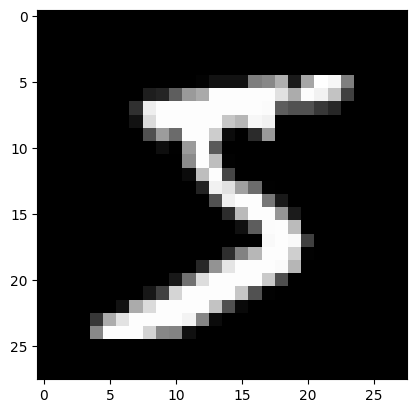

In [221]:
plt.imshow(X_train[0], cmap='gray')
print(y_train[0])
print(X_train[0].shape)

# Modelos

In [222]:

# Creamos el modelo de red neuronal Alta precisión
model_good = keras.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(10, activation='softmax')
])


# Creamos el modelo de red neuronal Media precisión
model_medium = keras.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(99, activation='softmax', kernel_initializer='ones', bias_initializer='ones'),
  keras.layers.Dense(28, activation='linear', kernel_initializer='ones', bias_initializer='ones'),
  keras.layers.Dense(10, activation='softmax')
])


# Creamos el modelo de red neuronal Baja precisión
model_bad = keras.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(33, activation='elu', kernel_initializer='ones', bias_initializer='ones'),
  keras.layers.Dense(88, activation='sigmoid', kernel_initializer='ones', bias_initializer='ones'),
  keras.layers.Dense(10, activation='softmax')
])


# Predecimos los modelos antes de entrenarlos

## Técnica de estimación
Programamos SynFlow

In [223]:
def linearize(model):
    """ 
    Get the absolute value of the weights of the model and return the signs of the weights 
    """
    signs = []
    for layer in model.layers:
        if len(layer.get_weights()) > 0:
            weights = layer.get_weights()
            layer_signs = [np.sign(w) for w in weights]
            new_weights = [np.abs(w) for w in weights]
            layer.set_weights(new_weights)
            signs.append(layer_signs)
    return signs

def compute_synflow_per_weight(model, input_shape):
    signs = linearize(model)  # Get the signs of the weights and transform the absolute value of the weights

    inputs = np.ones((1,) + input_shape)
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)

    with tf.GradientTape() as tape:
        outputs = model(inputs)
        loss = tf.reduce_sum(outputs)
    grads = tape.gradient(loss, model.trainable_variables)

    # Calculate SynFlow scores
    synflow_scores = []
    for w, g in zip(model.trainable_variables, grads):
        if tf.reduce_any(tf.math.is_nan(g)) or tf.reduce_any(tf.math.is_nan(w)):
            print("NaN detected in gradients or weights.")
            continue  # Skip to the next weight if NaN is detected
        synflow_scores.append(tf.abs(w * g).numpy())

    return synflow_scores

### Predicción de redes

In [224]:
import prettytable as pt

input_shape = (28, 28, 1)

# Compilamos los modelos
model_good.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_medium.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_bad.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Construimos los modelos
model_good.build()
model_medium.build()
model_bad.build()

score_model_good = compute_synflow_per_weight(model_good, input_shape)
score_model_medium = compute_synflow_per_weight(model_medium, input_shape)
score_model_bad = compute_synflow_per_weight(model_bad, input_shape)

# Score por capa
table = pt.PrettyTable()
table.field_names = ["Layer", "Good model"]
for i, score in enumerate(score_model_good):
  table.add_row([f"Layer {i}", np.sum(score)])
print(table)

table = pt.PrettyTable()
table.field_names = ["Layer", "Medium model"]
for i, score in enumerate(score_model_medium):
  table.add_row([f"Layer {i}", np.sum(score)])
print(table)

table = pt.PrettyTable()
table.field_names = ["Layer", "Bad model"]
for i, score in enumerate(score_model_bad):
  table.add_row([f"Layer {i}", np.sum(score)])
print(table)

# Score total
score_model_good = [np.sum(score) for score in score_model_good]
score_model_medium = [np.sum(score) for score in score_model_medium]
score_model_bad = [np.sum(score) for score in score_model_bad]

# Score total
table = pt.PrettyTable()
table.field_names = ["Model", "Synflow score"]
table.add_row(["Good model", np.sum(score_model_good)])
table.add_row(["Medium model", np.sum(score_model_medium)])
table.add_row(["Bad model", np.sum(score_model_bad)])
print(table)

+---------+--------------+
|  Layer  |  Good model  |
+---------+--------------+
| Layer 0 | 4.113576e-06 |
| Layer 1 |     0.0      |
+---------+--------------+
+---------+---------------+
|  Layer  |  Medium model |
+---------+---------------+
| Layer 0 |      0.0      |
| Layer 1 |      0.0      |
| Layer 2 |  6.860439e-07 |
| Layer 3 |  6.860439e-07 |
| Layer 4 | 1.3720883e-06 |
| Layer 5 |      0.0      |
+---------+---------------+
+---------+-----------+
|  Layer  | Bad model |
+---------+-----------+
| Layer 0 |    0.0    |
| Layer 1 |    0.0    |
| Layer 2 |    0.0    |
| Layer 3 |    0.0    |
| Layer 4 |    0.0    |
| Layer 5 |    0.0    |
+---------+-----------+
+--------------+---------------+
|    Model     | Synflow score |
+--------------+---------------+
|  Good model  |  4.113576e-06 |
| Medium model |  2.744176e-06 |
|  Bad model   |      0.0      |
+--------------+---------------+


# Entrenamos y obtenemos su accuracy

## Modelo de alta precisión

In [225]:
# seteamos la semilla
set_seed()

model_good.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

params = {
  'batch_size': 32,
  'validation_data': (X_test, y_test),
  'epochs': 5
}

# Entrenamos el modelo
model_good.fit(X_train, y_train, **params)
loss, accuracy = model_good.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.8306 - loss: 0.7034 - val_accuracy: 0.9155 - val_loss: 0.3073
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - accuracy: 0.9141 - loss: 0.3071 - val_accuracy: 0.9213 - val_loss: 0.2815
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step - accuracy: 0.9209 - loss: 0.2820 - val_accuracy: 0.9242 - val_loss: 0.2728
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.9241 - loss: 0.2705 - val_accuracy: 0.9242 - val_loss: 0.2687
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step - accuracy: 0.9261 - loss: 0.2635 - val_accuracy: 0.9242 - val_loss: 0.2664
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.9112 - loss: 0.3035
Loss: 0.2663857042789459, Accuracy: 0.9241999983787537


## Modelo de media precisión

In [226]:
# seteamos la semilla
set_seed()

model_medium.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

params = {
  'batch_size': 32,
  'validation_data': (X_test, y_test),
  'epochs': 5
}

# Entrenamos el modelo
model_medium.fit(X_train, y_train, **params)
loss, accuracy = model_medium.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 750us/step - accuracy: 0.1856 - loss: 2.1230 - val_accuracy: 0.2622 - val_loss: 1.7794
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.2627 - loss: 1.7441 - val_accuracy: 0.3181 - val_loss: 1.6408
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.3222 - loss: 1.6246 - val_accuracy: 0.3410 - val_loss: 1.5950
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.3748 - loss: 1.5863 - val_accuracy: 0.4073 - val_loss: 1.5735
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.4013 - loss: 1.5614 - val_accuracy: 0.4078 - val_loss: 1.5657
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.4035 - loss: 1.6131
Loss: 1.5656843185424805, Accuracy: 0.40779998898506165


## Modelo de baja precisión

In [227]:
# seteamos la semilla
set_seed()

model_bad.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

params = {
  'batch_size': 32,
  'validation_data': (X_test, y_test),
  'epochs': 5
}

# Entrenamos el modelo
model_bad.fit(X_train, y_train, **params)
loss, accuracy = model_bad.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 0.1024 - loss: 2.3227 - val_accuracy: 0.1135 - val_loss: 2.3107
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.1026 - loss: 2.3132 - val_accuracy: 0.1135 - val_loss: 2.3107
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.1026 - loss: 2.3132 - val_accuracy: 0.1135 - val_loss: 2.3107
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.1026 - loss: 2.3132 - val_accuracy: 0.1135 - val_loss: 2.3107
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.1026 - loss: 2.3132 - val_accuracy: 0.1135 - val_loss: 2.3107
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.1160 - loss: 2.3075
Loss: 2.310694456100464, Accuracy: 0.11349999904632568


## Prueba con red convolucional

In [230]:
convolutional_model = keras.Sequential([
  keras.layers.Input(shape=input_shape),
  keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
  keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
  keras.layers.MaxPooling2D((2, 2)),
  
  keras.layers.Conv2D(64, (3, 3), activation='tanh', padding='same', kernel_initializer='he_normal'),
  keras.layers.Conv2D(64, (3, 3), activation='tanh', padding='same', kernel_initializer='he_normal'),
  keras.layers.MaxPooling2D((2, 2)),

  keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal'),
  keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal'),

  keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same', kernel_initializer='he_normal'),
  keras.layers.Conv2D(64, (3, 3), activation='tanh', padding='same', kernel_initializer='he_normal'),
  keras.layers.Conv2D(64, (3, 3), activation='tanh', padding='same', kernel_initializer='he_normal'),
  
  keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same', kernel_initializer='he_normal'),
  keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal'),
  keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal'),

  keras.layers.Conv2D(1, (1, 1), activation='sigmoid')
])

# Mostramos el resumen del modelo
print(convolutional_model.summary())

# Compilamos el modelo
convolutional_model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# construimos el modelo
convolutional_model.build()

# Predecimos con synflow
score_convolutional_model = compute_synflow_per_weight(convolutional_model, input_shape)

# Score por capa
table = pt.PrettyTable()
table.field_names = ["Layer", "Convolutional model"]
for i, score in enumerate(score_convolutional_model):
  table.add_row([f"Layer {i}", np.sum(score)])
print(table)

# Score total
score_convolutional_model = [np.sum(score) for score in score_convolutional_model]

# Score total
table = pt.PrettyTable()
table.field_names = ["Model", "Synflow score"]
table.add_row(["Convolutional model", np.sum(score_convolutional_model)])
print(table)

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_498 (Conv2D)             │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_499 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_500 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_501 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_502 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_503 (Conv2D)             │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_87             │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_504 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_505 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_88             │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_506 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_507 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_508 (Conv2D)             │ (None, 28, 28, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,073 (1.80 MB)

 Trainable params: 471,073 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

None
+----------+---------------------+
|  Layer   | Convolutional model |
+----------+---------------------+
| Layer 0  |         0.0         |
| Layer 1  |         0.0         |
| Layer 2  |         0.0         |
| Layer 3  |         0.0         |
| Layer 4  |         0.0         |
| Layer 5  |         0.0         |
| Layer 6  |         0.0         |
| Layer 7  |         0.0         |
| Layer 8  |         0.0         |
| Layer 9  |         0.0         |
| Layer 10 |         0.0         |
| Layer 11 |         0.0         |
| Layer 12 |         0.0         |
| Layer 13 |         0.0         |
| Layer 14 |         0.0         |
| Layer 15 |         0.0         |
| Layer 16 |         0.0         |
| Layer 17 |         0.0         |
| Layer 18 |         0.0         |
| Layer 19 |         0.0         |
| Layer 20 |         0.0         |
| Layer 21 |         0.0         |
| Layer 22 |         0.0         |
| Layer 23 |         0.0         |
| Layer 24 |         0.0         |
| Layer 25 |   